# Description:
In this notebook the some of the properties of the antennas as simulated by NuRadioReco are investigated as a result of weird behaviour seen in simulation results.

We want to explain the two bobble shape of the simulated transit curve for St23Ch20:
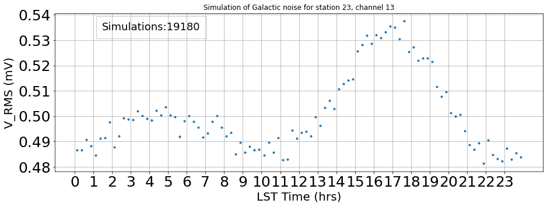

Start by looking at the antenna response:

# Import modules:

In [1]:
from GalaxyFunctions import *

# Import data

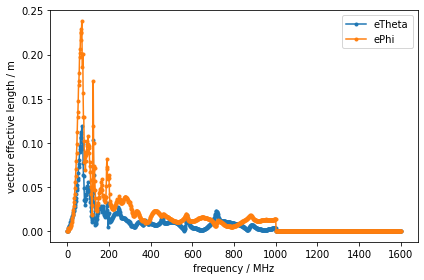

In [17]:
StNr,ChNr,Run,EvtNr,ThermalNoise,Plot=23,20,304,2030,False,False
import NuRadioReco.modules.channelGalacticNoiseAdder as ChannelGalacticNoiseAdder
import NuRadioReco.modules.channelGenericNoiseAdder as ChannelGenericNoiseAdder
import NuRadioReco.examples.cr_efficiency_analysis.helper_cr_eff as hcr
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units, ice, geometryUtilities
from NuRadioReco.framework import event,station, channel
import NuRadioReco.modules.RNO_G.hardwareResponseIncorporator
from datetime import datetime
from datetime import timedelta
import scipy.fft as scfft 
    
WaveFormFile=GetWaveformsFile(StNr,Run)
HeaderFile=GetHeaderFile(StNr,Run)
RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=WaveFormFile['waveforms']['event_number'].array(library="np")
TriggerTimes=HeaderFile['header']["trigger_time"].array(library='np')
    
EvIdx=np.where(EventNrs==EvtNr)[0][0]
Date=datetime.utcfromtimestamp(TriggerTimes[EvIdx])# - timedelta(hours=2, minutes=0)
    
#define relevant parameters
SamplingTimes=(1/(3.2*10**9))*np.arange(2048) #SampleTimes in seconds

#Obtaining path to relevant json file for detector description
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2022.json"

#Defining the instances of classes necessary for the simulation
GNDetector = detector.Detector(json_filename = detpath)#,antenna_by_depth=False)
GNDetector.update(Date) #date in example
GNEvent=event.Event(Run,EvtNr)
GNStation=station.Station(StNr)
GNStation.set_station_time(Date)
GNChannel=channel.Channel(ChNr)
GNChannel.set_trace(trace=np.zeros(2048), sampling_rate=3.2 * units.GHz)
GNStation.add_channel(GNChannel) 

channelGalacticNoiseAdder = ChannelGalacticNoiseAdder.channelGalacticNoiseAdder()
GNAntennaPatternProvider=NuRadioReco.detector.antennapattern.AntennaPatternProvider()
    
# signal income direction
#zenith, azimuth = np.deg2rad(0), np.deg2rad(0)
zenith, azimuth = np.deg2rad(80), np.deg2rad(270)

n_ice=ice.get_refractive_index(-0.01, GNDetector.get_site(GNStation.get_id()))
    
for channel in GNStation.iter_channels():
    
    ##Breking radio door ijs
    if GNDetector.get_relative_position(GNStation.get_id(), GNChannel.get_id())[2] < 0:
        t_theta = geometryUtilities.get_fresnel_t_p(zenith, n_ice, 1)
        t_phi = geometryUtilities.get_fresnel_t_s(zenith, n_ice, 1)
        fresnel_zenith = geometryUtilities.get_fresnel_angle(zenith, n_ice, 1.)
        if fresnel_zenith is None:
            continue
    else:
        t_theta = 1
        t_phi = 1
        fresnel_zenith = zenith
        
    #print(channel.get_id())
    antenna_pattern = GNAntennaPatternProvider.load_antenna_pattern(GNDetector.get_antenna_model(GNStation.get_id(), GNChannel.get_id()))
    antenna_orientation = GNDetector.get_antenna_orientation(GNStation.get_id(), GNChannel.get_id())
    freqs = channel.get_frequencies()
    VEL = antenna_pattern.get_antenna_response_vectorized(freqs, zenith, azimuth, *antenna_orientation)

fig, ax = plt.subplots(1, 1)
ax.plot(freqs / units.MHz, np.abs(VEL['theta']), '.-', label='eTheta')
ax.plot(freqs / units.MHz, np.abs(VEL['phi']), '.-', label='ePhi')
ax.set_xlabel("frequency / MHz")
ax.set_ylabel("vector effective length / m")
fig.tight_layout()
ax.legend()
plt.show()

In [21]:
def TransitCurveTest(StNr,ChNr,Runs,NBins=4*24,ZeroAvg=True,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=(-1,-1),FFTFilter=True,Lowpass=False,Plot=True):
    """
    Plots the Average V_RMS as a function of time of the day.
    Parameters:
    StNr,ChNr,Runs=Station number, channel number, list of runs 
    NBins=amount of bins to divide the full day in
    ZeroAvg=Boolean: if true, the timetraces will firs tbe zero averaged
    Lowpass= Boolean: if true, a butterworth lowpass filter will be applied in order to maintain only galactic noise dominated frequencies
    FFTFilter=Boolean: if true, applies a Notch filter to all frequency spectra to cut out frequencies which have shown to be potentially problematic
    TimeFormat= String: Dictates what timeformat the x-axis will be in. Options: "LST": local sidereal time, "LT": Local time & "UTC": UTC time
    Triggers=tupel of flags to dictate which triggers are allowed in the analysis. Events with different triggers are not used (0=has to be absent, 1=has to be present, anything else=both 0 and 1 can be used for analysis)
    StdCut=(AmtStd,StdCut) if larger than zero, all VRMS outliers above StdCut standard variations will be cut out of the analysis. This procedure is repeated AmtStd times.
    """
    (has_rf,has_ext,has_pps,has_soft)=Triggers
    NRuns=0
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    FilteredRuns,FilteredEvNrs=TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft)
    for Run in FilteredRuns:
        path=Path(StNr,Run)
        #if os.path.isfile(path+"/combined.root"):   
        if os.path.isfile(path+"/waveforms.root") and os.path.isfile(path+"/headers.root"):
            NRuns+=1
            # #If CombinedFile exists:
            # CombinedFile=GetCombinedFile(StNr,Run)
            # RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            # EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            # TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
            
            WaveFormFile=GetWaveformsFile(StNr,Run)
            HeaderFile=GetHeaderFile(StNr,Run)
            RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=WaveFormFile['waveforms']['event_number'].array(library="np")
            TriggerTimes=HeaderFile['header']["trigger_time"].array(library='np')
            
            RunIdx=np.where(FilteredRuns==Run)[0][0]

            for EvNr in FilteredEvNrs[RunIdx]: ####DO NOT FORGET TO DELETE [0]!!!!
                EvIdx=np.where(EventNrs==EvNr)[0][0]
                if np.isinf(TriggerTimes[EvIdx]):
                    print("Inf timestamp at: Run" + str(Run) + ", EvNr" + str(EvNr))
                    FilteredEvNrs[RunIdx]=np.delete(FilteredEvNrs[RunIdx],np.where(FilteredEvNrs[RunIdx]==EvNr)[0][0])
                    if len(FilteredEvNrs[RunIdx])==0:
                        FilteredRuns=np.delete(FilteredRuns, RunIdx)
                        FilteredEvNrs=np.delete(FilteredEvNrs, RunIdx)
                    continue
                print(RadiantData[EvIdx][ChNr])
                VoltageTrace=ADCtoVoltage(RadiantData[EvIdx][ChNr]) #The timetrace data in voltage
                if ZeroAvg==True:
                    Vmean=np.mean(VoltageTrace)
                    VoltageTrace-=Vmean
                if FFTFilter or Lowpass:
                    import scipy.fft as scfft
                    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
                    TimeStep=1/sampling_rate #Time between two samples
                    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
                    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
                    freq=np.fft.fftshift(freq)
                    TotalFilter=np.ones(len(freq))
                    if FFTFilter:
                        TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
                    if Lowpass:
                        CritFreq=110*10**6
                        TotalFilter=np.multiply(TotalFilter,LowpassButter(CritFreq,20,freq))
                    FFT=scfft.fft(VoltageTrace)
                    FFT=np.fft.fftshift(FFT)
                    FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
                    VoltageTrace=np.abs(scfft.ifft(FFT))
                EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in VoltageTrace])))
                if TimeFormat=="LST":
                    EventTime=np.append(EventTime,LST(TriggerTimes,EvIdx))
                elif TimeFormat=="LT": #Greenland Timezone is UTC-3
                    EventTime=np.append(EventTime,LT(TriggerTimes,EvIdx))
                else:
                    print("Please enter a valid TimeFormat")
                    return
     
#     EventTimeCounts, EventTimeBins=np.histogram(EventTime, bins=NBins,range=(0,24),density=False) #Storing timestamps in histogram format
#     MidBins= np.array([(EventTimeBins[i] + EventTimeBins[i+1])/2 for i in range(0,len(EventTimeBins)-1)])
#     #Make a histogram of the V_RMS value fully added in its respective bin by adding V_RMS as a weigth to the additions to the histogram
       
#     EventTimeDig=np.digitize(EventTime,EventTimeBins)
#     VRMSIdx=np.arange(len(EventRMS))
#     GroupedVRMS=np.empty((NBins,),dtype=object)
#     GroupedVRMSIdx=np.empty((NBins,),dtype=object)
#     for i in range(len(EventTimeDig)):
#         GroupedVRMS[EventTimeDig[i]-1]=np.append(GroupedVRMS[EventTimeDig[i]-1],EventRMS[i])
#         GroupedVRMSIdx[EventTimeDig[i]-1]=np.append(GroupedVRMSIdx[EventTimeDig[i]-1],VRMSIdx[i])
#     ##Get rid of "None" entries in beginning of array
#     for i in range(len(GroupedVRMS)):
#         GroupedVRMS[i]=np.delete(GroupedVRMS[i], 0)
#         GroupedVRMSIdx[i]=np.delete(GroupedVRMSIdx[i], 0)
    print(EventRMS)
    MidBins, GroupedVRMS=GroupVRMS(EventRMS,EventTime,NBins)

    ####Quality cuts:
    ##Hard cut
    if False:
        HardCut=0.0035 #Cut of VRMS in Voltage
        for i in range(len(GroupedVRMS)):
            for VRMSIdx, VRMS in enumerate(GroupedVRMS[i]):
                if VRMS>HardCut:
                    EventRMSIdx=np.where(EventRMS==VRMS)[0][0]
                    FilteredRuns,FilteredEvNrs=StdCutRunEvtsFilter(EventRMSIdx,FilteredRuns,FilteredEvNrs)
                    EventRMS=np.delete(EventRMS, EventRMSIdx)
                    EventTime=np.delete(EventTime, EventRMSIdx)
                    GroupedVRMS[i]=np.delete(GroupedVRMS[i], np.where(GroupedVRMS[i]==VRMS)[0][0])

    ##Std Cut
    if np.all(np.array(StdCut)>0):
        for StdAmt in range(StdCut[0]):
            #Compute std per bin
            ## Here you do not divide std by sqrt(len(GroupedVRMS[i])) because here you want to use the width of the distribution and not the uncertainty on the mean!!!
            VRMSStd=np.array([np.std(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
            VRMSMedian=np.array([np.median(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
            for i in range(len(GroupedVRMS)):
                for VRMSIdx, VRMS in enumerate(GroupedVRMS[i]):
                    if not VRMSMedian[i] - StdCut[1]*VRMSStd[i]<VRMS<VRMSMedian[i] + StdCut[1]*VRMSStd[i]:
                        EventRMSIdx=np.where(EventRMS==VRMS)[0][0]
                        FilteredRuns,FilteredEvNrs=StdCutRunEvtsFilter(EventRMSIdx,FilteredRuns,FilteredEvNrs)
                        EventRMS=np.delete(EventRMS, EventRMSIdx)
                        EventTime=np.delete(EventTime, EventRMSIdx)
                        GroupedVRMS[i]=np.delete(GroupedVRMS[i], np.where(GroupedVRMS[i]==VRMS)[0][0])
    
    if Plot:
        EventRMSCounts, EventRMSBins=np.histogram(EventTime, bins=NBins,range=(0,24),density=False,weights=EventRMS) 
        
        VRMSAvg=np.array([np.mean(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
        VRMSStd=np.array([np.std(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])

        plt.figure(figsize=(15,5))
        plt.figtext(0.2, 0.8, "Entries:" + str(len(EventTime)), fontsize=18,bbox=dict(edgecolor='black', facecolor='none', alpha=0.2, pad=10.0))
        plt.errorbar(MidBins,1000*VRMSAvg,yerr=1000*VRMSStd,fmt=".",zorder=2)
        for i in range(len(GroupedVRMS)):
            plt.plot(MidBins[i]*np.ones(len(GroupedVRMS[i])),1000*GroupedVRMS[i],"r.", alpha=0.5,zorder=1)
        plt.grid(color='grey', linestyle='-', linewidth=1,alpha=0.5)
        plt.title("V_RMS of Station " + str(StNr) + ", channel " + str(ChNr) + " for " + str(NRuns) + " events between run " + str(Runs[0]) + " and run " + str(Runs[-1]) + " throughout the day for " + str(NBins) + " bins")
        plt.xlabel(TimeFormat + " Time (hrs)",fontsize=20)#20)
        plt.ylabel("V_RMS (mV)",fontsize=20)#20)
        plt.xticks(np.arange(0, 24, 1.0),fontsize=25)#15)
        plt.yticks(fontsize=25)#15)
        plt.show()
    return EventTime, EventRMS, MidBins, GroupedVRMS, FilteredRuns,FilteredEvNrs

[  3   7   6 ...  12  -1 -13]
[ 0 -7 -3 ...  1 -6 -5]
[  2   6   7 ... -14 -13 -19]
[ 1  8 13 ... -9 -4 -2]
[ 1 12 18 ...  0  8 20]
[-16 -14  -4 ...  14  16   8]
[  7 -11 -17 ...   7   0  -7]
[ 3  1  0 ... -1  3 11]
[-1 -7 -6 ... -4 -7 -4]
[13 34 28 ... -1 -4 -4]
[-21 -14   1 ...  -8  -4   5]
[-10  -9   7 ...  12  17  18]
[-6 -8 -8 ... -5  0  9]
[-15 -22 -27 ...  -2  -2  -5]
[15 12  2 ... -1  5 10]
[ -1  12  20 ... -15 -10   3]
[ -8  -6   0 ...   0 -11  -9]
[  8  19  18 ... -10  -9 -14]
[-21 -31 -21 ... -13 -14   3]
[ 3 -4 -5 ...  0 11 16]
[ 3  4  0 ... -4  0  6]
[-10  -6   3 ...  -3   5   0]
[  0 -17 -17 ...  13   8   2]
[ 1 -2 -4 ... -8  5 14]
[ -1 -10  -9 ...   7   0  -9]
[ -7 -14  -8 ...   0   8  10]
[ 8  2  3 ... -3 -3  4]
[ 8 10  9 ... -7 -1 10]
[ -2 -11 -11 ...   5 -10 -22]
[19 26 12 ... -8 -9 -9]
[-12 -15  -5 ...   3   8   1]
[-11 -14 -12 ...   8   4  -4]
[ -1  -5  -9 ...  -9 -13  -7]
[  1   7  10 ... -28 -22 -18]
[  8   3 -10 ...  10  13   3]
[-5 -1 -5 ... -1  0  3]
[ 11  14  

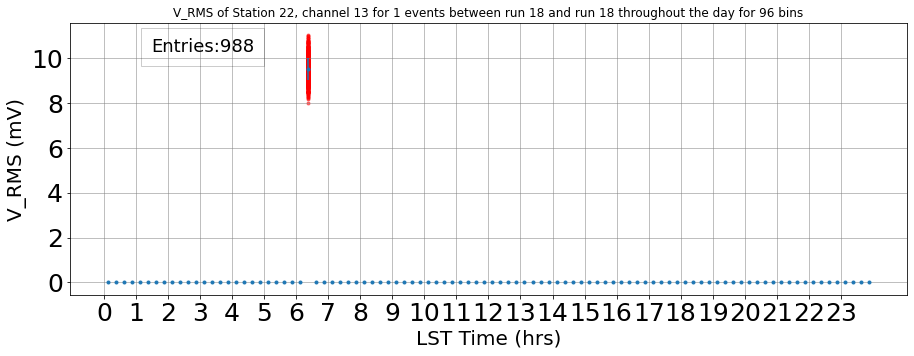

(array([6.41117298, 6.41127149, 6.41132773, 6.4114232 , 6.41147947,
        6.411575  , 6.41163446, 6.41173001, 6.41181424, 6.41191   ,
        6.41199414, 6.41209024, 6.41218578, 6.41227004, 6.41236573,
        6.41244996, 6.4125463 , 6.41264178, 6.41269801, 6.4127937 ,
        6.41287785, 6.41297471, 6.41305948, 6.41315436, 6.41325059,
        6.41330676, 6.41340247, 6.41348664, 6.41358415, 6.41366825,
        6.41376319, 6.41385885, 6.41391506, 6.41401091, 6.41409509,
        6.41419324, 6.41427892, 6.41437427, 6.41447136, 6.41452762,
        6.41462468, 6.41468162, 6.41477726, 6.41486139, 6.41495696,
        6.41504111, 6.41513638, 6.41523184, 6.41531591, 6.41541142,
        6.41549559, 6.41559061, 6.41568792, 6.41574536, 6.41584376,
        6.41589994, 6.41599542, 6.41607962, 6.41617602, 6.41626016,
        6.41635518, 6.41645075, 6.41653488, 6.41663053, 6.41671472,
        6.4168098 , 6.41690528, 6.41696147, 6.41705987, 6.41714404,
        6.41723961, 6.41732376, 6.41741911, 6.41

In [22]:
RunList=np.concatenate((np.arange(18,23),np.arange(91,111)))
for BadRun in [97,98]:
    RunList=np.delete(RunList,np.where(RunList==BadRun)[0][0])
TransitCurveTest(22,13,[18],NBins=4*24,ZeroAvg=False,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=(-1,-1),FFTFilter=False,Lowpass=False,Plot=True)

In [23]:
print(FilteredEvNrs[0][0],FilteredEvNrs[0][-1])
print(all(FilteredEvNrs[0]==np.arange(0,22965)))

0 22964
True


In [4]:
StNr,ChNr,RunNr=22,13,21
WaveFormFile=GetWaveformsFile(StNr,RunNr)
HeaderFile=GetHeaderFile(StNr,RunNr)
RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=WaveFormFile['waveforms']['event_number'].array(library="np")
TriggerTimes=HeaderFile['header']["trigger_time"].array(library='np')
TriggerInfo=TrigInfo(StNr,ChNr,RunNr)

In [8]:
EvIdx=np.where(EventNrs==22962)[0][0]
Triggers=[TriggerInfo['trigger_info.which_radiant_trigger'][EvIdx]<-100,TriggerInfo["trigger_info.ext_trigger"][EvIdx],TriggerInfo["trigger_info.pps_trigger"][EvIdx],TriggerInfo["trigger_info.force_trigger"][EvIdx]]
print(Triggers)

[True, False, False, False]


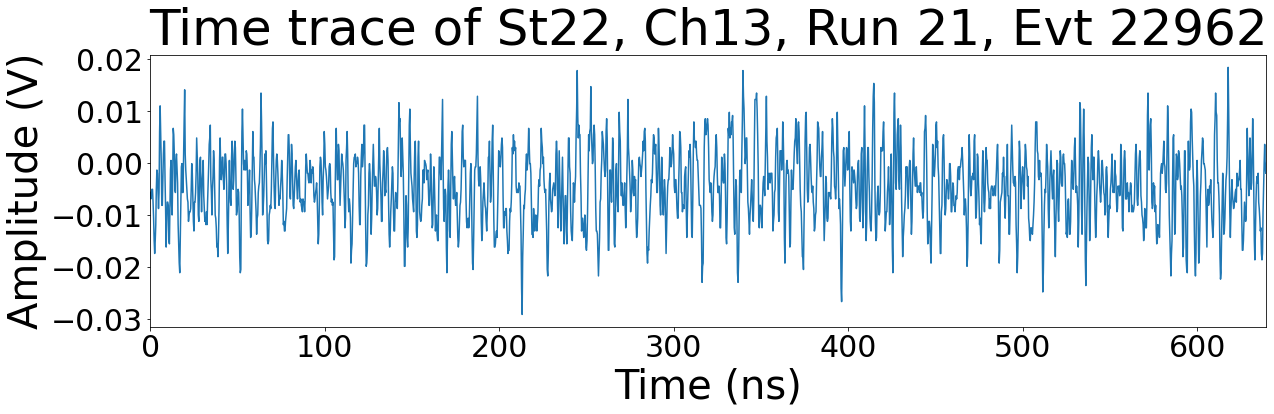

In [3]:
StNr,ChNr,RunNr=22,13,21
TimeTrace(StNr,ChNr,RunNr,22962,Amplitude="V")

In [34]:
int(1/0.8)

1

In [38]:
for i in range(1,100):
    print(i,1/i)

1 1.0
2 0.5
3 0.3333333333333333
4 0.25
5 0.2
6 0.16666666666666666
7 0.14285714285714285
8 0.125
9 0.1111111111111111
10 0.1
11 0.09090909090909091
12 0.08333333333333333
13 0.07692307692307693
14 0.07142857142857142
15 0.06666666666666667
16 0.0625
17 0.058823529411764705
18 0.05555555555555555
19 0.05263157894736842
20 0.05
21 0.047619047619047616
22 0.045454545454545456
23 0.043478260869565216
24 0.041666666666666664
25 0.04
26 0.038461538461538464
27 0.037037037037037035
28 0.03571428571428571
29 0.034482758620689655
30 0.03333333333333333
31 0.03225806451612903
32 0.03125
33 0.030303030303030304
34 0.029411764705882353
35 0.02857142857142857
36 0.027777777777777776
37 0.02702702702702703
38 0.02631578947368421
39 0.02564102564102564
40 0.025
41 0.024390243902439025
42 0.023809523809523808
43 0.023255813953488372
44 0.022727272727272728
45 0.022222222222222223
46 0.021739130434782608
47 0.02127659574468085
48 0.020833333333333332
49 0.02040816326530612
50 0.02
51 0.019607843137254